<a href="https://colab.research.google.com/github/sahrodion/30daysofCode/blob/main/Natural_Disaster_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision.transforms as transforms
# import torchvision.datasets as datasets
import torchvision.models as models
import torchvision


from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import copy
from collections import namedtuple
import os
import random
import shutil
import time
import collections
import math

In [ ]:
import glob
import cv2
from PIL import Image
import torchvision.transforms.functional as fn

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#USING OpenCV LIBRARY TO READ AND RESIZE THE IMAGES

#Resize Earthquake class
inputfolder = '/content/drive/MyDrive/dataset/DisasterModel/Cyclone_Wildfire_Flood_Earthquake_Dataset/Earthquake'
outputfolder = '/content/AssessmentDatasetResized/Earthquake'

# Create output folder if it doesn't exist
if not os.path.exists(outputfolder):
    os.makedirs(outputfolder)

i = 1

for img in glob.glob(inputfolder + '/*.jpg'):
    image = cv2.imread(img)
    if image is None:
        print("Error: Could not read image file", img)
        continue
    imgResized = cv2.resize(image, (32, 32))
    outputfile = 'earthquake%i.jpg' % i
    outputpath = os.path.join(outputfolder, outputfile)
    #print('Writing image to:', outputpath)
    cv2.imwrite(outputpath, imgResized)
    i += 1

print('Resizing completed successfully!')


#Resize Wildfire class
inputfolder = '/content/drive/MyDrive/dataset/DisasterModel/Cyclone_Wildfire_Flood_Earthquake_Dataset/Wildfire'
outputfolder = '/content/AssessmentDatasetResized/Wildfire'

# Create output folder if it doesn't exist
if not os.path.exists(outputfolder):
    os.makedirs(outputfolder)

i = 1

for img in glob.glob(inputfolder + '/*.jpg'):
    image = cv2.imread(img)
    #if image is None:
        #print("Error: Could not read image file", img)
        #continue
    imgResized = cv2.resize(image, (32, 32))
    outputfile = 'wildfire%i.jpg' % i
    outputpath = os.path.join(outputfolder, outputfile)
    #print('Writing image to:', outputpath)
    cv2.imwrite(outputpath, imgResized)
    i += 1

print('Resizing completed successfully!')


#Resize Cyclone class
inputfolder = '/content/drive/MyDrive/dataset/DisasterModel/Cyclone_Wildfire_Flood_Earthquake_Dataset/Cyclone'
outputfolder = '/content/AssessmentDatasetResized/Cyclone'

# Create output folder if it doesn't exist
if not os.path.exists(outputfolder):
    os.makedirs(outputfolder)

i = 1

for img in glob.glob(inputfolder + '/*.jpg'):
    image = cv2.imread(img)
    #if image is None:
        #print("Error: Could not read image file", img)
        #continue
    imgResized = cv2.resize(image, (32, 32))
    outputfile = 'cyclone%i.jpg' % i
    outputpath = os.path.join(outputfolder, outputfile)
    #print('Writing image to:', outputpath)
    cv2.imwrite(outputpath, imgResized)
    i += 1

print('Resizing completed successfully!')


#Resize Flood class
inputfolder = '/content/drive/MyDrive/dataset/DisasterModel/Cyclone_Wildfire_Flood_Earthquake_Dataset/Flood'
outputfolder = '/content/AssessmentDatasetResized/Flood'

# Create output folder if it doesn't exist
if not os.path.exists(outputfolder):
    os.makedirs(outputfolder)

i = 1

for img in glob.glob(inputfolder + '/*.jpg'):
    image = cv2.imread(img)
    #if image is None:
        #print("Error: Could not read image file", img)
        #continue
    imgResized = cv2.resize(image, (32, 32))
    outputfile = 'flood%i.jpg' % i
    outputpath = os.path.join(outputfolder, outputfile)
    #print('Writing image to:', outputpath)
    cv2.imwrite(outputpath, imgResized)
    i += 1

print('Resizing completed successfully!')

Resizing completed successfully!
Resizing completed successfully!
Resizing completed successfully!
Resizing completed successfully!


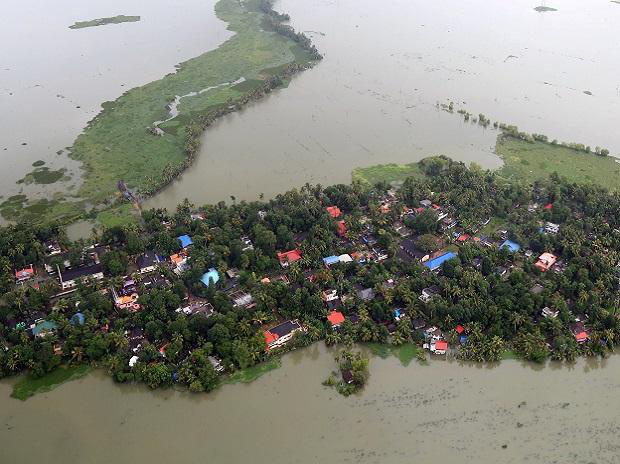

In [ ]:
img_v = Image.open('/content/drive/MyDrive/dataset/DisasterModel/Cyclone_Wildfire_Flood_Earthquake_Dataset/Flood/10.jpg')
img_v

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

In [ ]:
splitfolders.ratio('/content/drive/MyDrive/dataset/DisasterModel/Cyclone_Wildfire_Flood_Earthquake_Dataset/AssessmentDatasetResized/', output='/content/AssessmentDatasetSplit/',
    seed=1335, ratio=(0.6,0.2,0.2), group_prefix=None, move=False)

Copying files: 4428 files [00:11, 400.97 files/s]


In [ ]:
batch_size = 30
transform_train = torchvision.transforms.Compose([
    # Scale the image up to a square of 32 pixels in both height and width
    #torchvision.transforms.Resize(32),
    # Randomly crop a square image of 32 pixels in both height and width to
    # produce a small square of 0.64 to 1 times the area of the original
    # image, and then scale it to a square of 32 pixels in both height and
    # width

    #This transform is used as a data augmentation technique for image classification tasks to help prevent overfitting and improve the generalization performance of the model.
    #Random flipping is an augumentation technique that helps improve the model's generalization.
    # torchvision.transforms.RandomResizedCrop(32, scale=(1.0, 1.0),
    #                                                ratio=(1.0, 1.0)),

    torchvision.transforms.RandomResizedCrop(64, scale=(0.5, 1),
                                           ratio=(3.0/4.0, 4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5226, 0.4888, 0.4706],
                                      std=[0.1643, 0.1624, 0.1658])])

transform_test = torchvision.transforms.Compose([
    #torchvision.transforms.Resize(32),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5226, 0.4888, 0.4706],
                                    std=[0.1643, 0.1624, 0.1658])])

In [ ]:
data_dir = '/content/drive/MyDrive/dataset/DisasterModel/Cyclone_Wildfire_Flood_Earthquake_Dataset/'

train_ds, train_valid_ds = [datasets.ImageFolder(
    os.path.join(data_dir, 'DatasetSplit', folder),
    transform=transform_train) for folder in ['train', 'train_val']]

valid_ds, test_ds = [datasets.ImageFolder(
    os.path.join(data_dir, 'DatasetSplit', folder),

    transform=transform_test) for folder in ['val', 'test']]

In [ ]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

NameError: ignored

In [ ]:
means = torch.zeros(4, 3) #Four classes, 3 channels
stds = torch.zeros(4, 3)

for img, label in train_ds:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_ds)
stds /= len(train_ds)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')


NameError: ignored

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

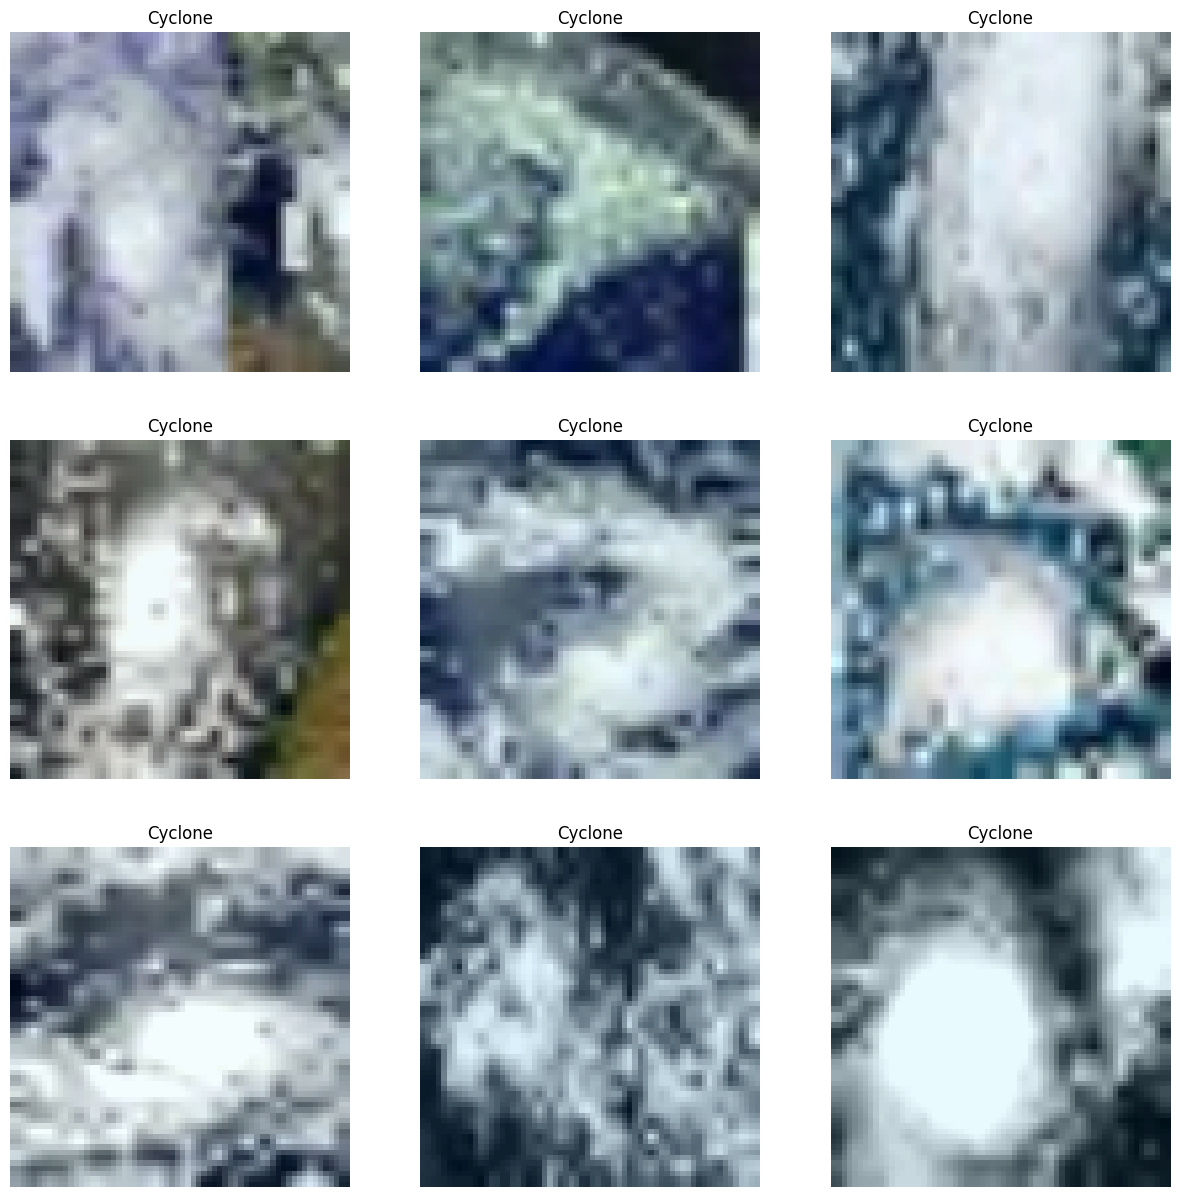

In [ ]:
N_IMAGES = 12

images, labels = zip(*[(image, label) for image, label in
                           [train_ds[i] for i in range(N_IMAGES)]])

classes = train_ds.classes

plot_images(images, labels, classes)

In [ ]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()

        block, n_blocks, channels = config
        self.in_channels = channels[0]

        assert len(n_blocks) == len(channels) == 4

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):

        layers = []

        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))

        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)

        return x, h

class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

class Bottleneck(nn.Module):

    expansion = 4

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)

        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [ ]:
# Load pre-trained ResNet-50 model
pretrained_model = models.resnet50(pretrained = True)
IN_FEATURES = pretrained_model.fc.in_features
OUTPUT_DIM = len(train_ds.classes)

# Replace the fully connected layer with a new one
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc

# Create a new instance of the ResNet model
model = ResNet(resnet50_config, OUTPUT_DIM)

# Load the state dictionary from the pre-trained model
model.load_state_dict(pretrained_model.state_dict())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]


<All keys matched successfully>

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,516,228 trainable parameters


In [ ]:
EPOCHS = 30

In [ ]:
import torch.optim as optim
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader

learning_rates = [1e-2, 1e-3, 1e-4]  # List of learning rates to try

best_accuracy = 0.0
best_learning_rate = None

for lr in learning_rates:
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valid_ds, batch_size=batch_size)

    for epoch in range(EPOCHS):
        # Training loop
        model.train()
        running_loss = 0.0

        for step, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation loop
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total

        print(f'Epoch: {epoch+1}/{EPOCHS}, Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%')

        # Check if this learning rate gives better accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_learning_rate = lr

print(f'Best learning rate: {best_learning_rate}, Best accuracy: {best_accuracy:.2f}%')


Epoch: 1/30, Loss: 61.5936, Accuracy: 45.05%
Epoch: 2/30, Loss: 69.1437, Accuracy: 29.95%
Epoch: 3/30, Loss: 46.3802, Accuracy: 66.75%
Epoch: 4/30, Loss: 38.3224, Accuracy: 61.32%
Epoch: 5/30, Loss: 36.6919, Accuracy: 74.06%
Epoch: 6/30, Loss: 31.8045, Accuracy: 64.15%
Epoch: 7/30, Loss: 31.4157, Accuracy: 67.45%
Epoch: 8/30, Loss: 29.6989, Accuracy: 71.23%
Epoch: 9/30, Loss: 27.5911, Accuracy: 70.05%
Epoch: 10/30, Loss: 28.7350, Accuracy: 66.98%
Epoch: 11/30, Loss: 28.3403, Accuracy: 79.25%
Epoch: 12/30, Loss: 27.9302, Accuracy: 69.10%
Epoch: 13/30, Loss: 26.5710, Accuracy: 81.37%
Epoch: 14/30, Loss: 24.8148, Accuracy: 79.72%
Epoch: 15/30, Loss: 24.2631, Accuracy: 80.19%
Epoch: 16/30, Loss: 21.9917, Accuracy: 69.10%
Epoch: 17/30, Loss: 24.9235, Accuracy: 77.83%
Epoch: 18/30, Loss: 21.8060, Accuracy: 79.48%
Epoch: 19/30, Loss: 21.4261, Accuracy: 79.01%
Epoch: 20/30, Loss: 24.3269, Accuracy: 79.48%
Epoch: 21/30, Loss: 21.8867, Accuracy: 86.79%
Epoch: 22/30, Loss: 20.7529, Accuracy: 66.9

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

#Learning rate
FOUND_LR = 1e-4

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]

optimizer = optim.Adam(params, lr = FOUND_LR)

In [ ]:
EPOCHS = 30
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [ ]:
def calculate_topk_accuracy(y_pred, y, k = 2): #This is to replace the d2l timer
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [ ]:
def train(model, iterator, optimizer, criterion, scheduler, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()

    for (x, y) in iterator:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        scheduler.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train(model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss: #to get the best loss
        best_valid_loss = valid_loss
       # print(epoch)
        torch.save(model.state_dict(), 'best-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.038 | Train Acc @1:  98.57% | Train Acc @5:  99.92%
	Valid Loss: 0.448 | Valid Acc @1:  85.95% | Valid Acc @5:  92.86%
Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 0.041 | Train Acc @1:  98.81% | Train Acc @5:  99.92%
	Valid Loss: 0.784 | Valid Acc @1:  67.14% | Valid Acc @5:  80.48%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.071 | Train Acc @1:  97.94% | Train Acc @5:  99.84%
	Valid Loss: 0.497 | Valid Acc @1:  81.43% | Valid Acc @5:  91.43%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.128 | Train Acc @1:  95.63% | Train Acc @5:  99.37%
	Valid Loss: 0.757 | Valid Acc @1:  67.14% | Valid Acc @5:  96.67%
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.193 | Train Acc @1:  94.52% | Train Acc @5:  98.97%
	Valid Loss: 0.293 | Valid Acc @1:  91.43% | Valid Acc @5:  98.57%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.207 | Train Acc @1:  93.89% | Train Acc @5:  98.89%
	Valid Loss: 0.139 | Valid Acc @1:  94.52% | Valid Acc @5: 100.00%
Epoch: 07 | 

In [ ]:
def get_predictions(model, iterator): #Help p,lot the graph

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
#@title TEST CODE TO SAVE RESULT AS CSV
#TEST CODE

import pandas as pd

def get_predictions(model, iterator, csv_filename):
    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            top_pred = y_prob.argmax(1, keepdim=True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    # Create a DataFrame from the predictions
    df = pd.DataFrame({
        'image': images,
        'label': labels,
        'probabilities': probs
    })

    # Save the DataFrame to a CSV file
    df.to_csv(csv_filename)

    return images, labels, probs